In [1]:
%matplotlib notebook
# Dependencies
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import os

from bs4 import BeautifulSoup

In [2]:
exp_name = "EQ59_Gly_02022021"
acq_name = "TileScan_Tp1-5"

exp_folder = os.path.join("D:", "Tolga", "Colony Images", f"{exp_name}")
base_folder = os.path.join(exp_folder, f"{exp_name}_{acq_name}")

base_folder


'D:Tolga\\Colony Images\\EQ59_Gly_02022021\\EQ59_Gly_02022021_TileScan_Tp1-5'

In [3]:
def collect_metadata(base_folder, exp_name, acq_name):
    exp_folder = f"D:/Tolga/Colony Images/{exp_name}/"
    base_folder = os.path.join(exp_folder, f"{exp_name}_{acq_name}/")
    metadata_folder = os.path.join(base_folder, "MetaData/")

    xml_path = metadata_folder + f"{exp_name}_{acq_name}_Properties.xml"

    # Read xml and prepare for the soup
    with open(xml_path) as fp:
        soup = BeautifulSoup(fp, "xml")

    # Check for merged?
    # Collect info about the tilescan
    tilescan_info = soup.find_all("Tile")
    # Variables to keep the information
    xix_lst = np.zeros(len(tilescan_info), dtype=np.int32)
    yix_lst = np.zeros_like(xix_lst)
    xpos_lst = np.zeros_like(xix_lst, dtype=np.double)
    ypos_lst = np.zeros_like(yix_lst, dtype=np.double)
    # Run through each tile and save the position
    for tile_idx in range(len(tilescan_info)):
        tile = tilescan_info[tile_idx]
        xix_lst[tile_idx] = tile.get("FieldX")
        yix_lst[tile_idx] = tile.get("FieldY")
        xpos_lst[tile_idx] = tile.get("PosX")
        ypos_lst[tile_idx] = tile.get("PosY")
        xpos_lst[tile_idx] *= 1e6 
        ypos_lst[tile_idx] *= 1e6

    xix_unique_ar = np.unique(xix_lst)
    yix_unique_ar = np.unique(yix_lst)
    tiles = {"xix_lst": xix_lst,
            "yix_lst": yix_lst,
            "xix_unique_ar": xix_unique_ar,
            "yix_unique_ar": yix_unique_ar,
            "xpos_lst": xpos_lst,
            "ypos_lst": ypos_lst,
            "tile_xcnt": len(xix_unique_ar),
            "tile_ycnt": len(yix_unique_ar)}

    # Collect dimenions: x,y,z,t,stage (stage gives info about tilescan)
    dimension_desc = soup.find_all("DimensionDescription")
    dimensions = {}
    for desc in dimension_desc:
        dimid = desc.get("DimID")
        unit = desc.get("Unit").replace("\xb5", "u")[-2:] # Replace greek letter of \mu with letter u
        length = desc.get("Length")
        counts = np.int32(desc.get("NumberOfElements"))
        voxel = desc.get("Voxel")
        # convert all length values to um
        if len(unit) > 0:   # implies a numerical value
            length = np.double(length)
            voxel = np.double(voxel)
            if unit == "mm":
                length *= 1000
                voxel *= 1000
                unit = "um"
        dimensions[dimid] = {"Length": length,
                             "NumberOfElements": counts,
                             "Unit": unit,
                             "Voxel": voxel
                            }

    return {"dimensions": dimensions,
            "tiles": tiles,
            "base_folder": base_folder,
            "exp_name": exp_name,
            "acq_name": acq_name,
            "xml_path": xml_path}
            # Add base_folder, exp_name, acq_name



In [4]:
metadata = collect_metadata(base_folder, exp_name, acq_name)
metadata

{'dimensions': {'X': {'Length': 116.24,
   'NumberOfElements': 512,
   'Unit': 'um',
   'Voxel': 0.227},
  'Y': {'Length': 116.24,
   'NumberOfElements': 512,
   'Unit': 'um',
   'Voxel': 0.227},
  'Z': {'Length': -1000.0,
   'NumberOfElements': 234,
   'Unit': 'um',
   'Voxel': -4.0},
  'Stage': {'Length': '0.00',
   'NumberOfElements': 36,
   'Unit': '',
   'Voxel': None},
  'T': {'Length': '4h00m0.560s',
   'NumberOfElements': 5,
   'Unit': '',
   'Voxel': '0 s'}},
 'tiles': {'xix_lst': array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
         3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5]),
  'yix_lst': array([0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3,
         4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5]),
  'xix_unique_ar': array([0, 1, 2, 3, 4, 5]),
  'yix_unique_ar': array([0, 1, 2, 3, 4, 5]),
  'xpos_lst': array([80257.4494308, 80257.4494308, 80257.4494308, 80257.4494308,
         80257.4494308, 80257.4494308, 80354.454318 , 80354.454318 

In [5]:
# Block is defined by the x and y values of each edge
class Block:
    # __init__(self, left_top, right_bottom, width, height, xvoxel, yvoxel):
    def __init__(self, left_top, right_bottom, width, height, xvoxel, yvoxel):
        """
            @param left_top: The location of the left_top point
            @param right_bottom: The location of the right bottom
            @param width: Number of pixels in x
            @param height: Number of pixels in y
            @param xvoxel: width of each pixel in physical length
            @param yvoxel: height of each pixel in physical length
            
            left_top and right_bottom are calculated from the xml.properties file inside the Metadata folder
            The edges self.left, self.right, self.top and self.bottom defines the corresponding edges
            
            self.xidx and self.yidx are the indices that would correspond to the image
            
            Purpose of this class:
            The tilescan images have overlapping grids, so to merge all the grid-based tilescan images, 
            we need to redefine the block in the positions of each grid block
            
            How to use:
            First, we initialize each block with the overlapping coordinates. Then, consequentially, fix the overlapping
            coordinates by using the function overlap_fix(block). The parameter block here is an object of Block, which is near.
            The overlap_fix first checks where the overlap occurs with the block, then redefines the overlapping edge
            
            Note: The overlap_fix function consequentially assume overlapping blocks have the same non-overlapping position.
                Make sure to check this with the plot below.
        """
        # Edges
        self.left = left_top[0]
        self.right = right_bottom[0]
        self.top = left_top[1]
        self.bottom = right_bottom[1]
        
        # x,y pixel count
        self.width = width
        self.height = height
        # x and y pixel size in physical length
        self.xvoxel = xvoxel
        self.yvoxel = yvoxel
        # x,y pixel indices
        self.xidx = np.arange(self.width)
        self.yidx = np.arange(self.height)
        
    # def is_inside_h(self, y):
    #     # Checks whether the y-coordinate is inside the horizontal range defined by the block
    #     if self.bottom < y and self.top > y:
    #         return True
    #     else:
    #         return False
    # def is_inside_v(self, x):
    #     # Checks whether the x-coordinate is inside the vertical range defined by the block
    #     if self.left < x and self.right > x:
    #         return True
    #     else:
    #         return False
    # def is_inside(self, x, y):
    #     """
    #         There must be a check for the microscope parameters flipx and swap-xy
    #         The function returns true if the given location is inside the block
            
    #     """
    #     print("Comparing x- (%g,%g) -- %g" % (left,right, x))
    #     print("Comparing y- (%g,%g) -- %g" % (bottom, top, y))
    #     if self.left < x and self.right > x and self.bottom < y and self.top > y: # inside the block
    #         return True
    #     else:
    #         return False
    def remove_left(self, right, xsz): # Remove the overlapping pixels up to right
        # The length of the overlap
        length = right - self.left
#         print("x - Length = ", length)
        # self.left = right
        # Overlapping is removed
        self.xidx = np.arange(int(length/self.xvoxel), xsz)
#         print("First x-index = ", self.xidx[0])
    def remove_bottom(self, top, ysz): # Remove the overlapping pixels up to top
        # The length of the overlap
        length = top - self.bottom
#         print("y - Length = ", length)
        # selt.
        # Overlapping is removed
        self.yidx = np.arange(int(length/self.yvoxel), ysz)
#         print("First y-index = ", self.yidx[0])
        
    # def overlap_fix(self, block):
    #     # Overlap on the right --> Right of the self block is the left of the param block
    #     if self.is_inside_v(block.left):
    #         block.remove_left(self.right)
    #     if self.is_inside_h(block.bottom):
    #         block.remove_bottom(self.top)
        

In [6]:
def merge(metadata): # For now, assumes all the acquire is xyzt

    ###############################
    #### Construct the filepaths for each tilescan tif image
    ###############################
    # Construct the filepaths to collect the tilescan images based on the provided metadata
    znum = metadata["dimensions"]["Z"]["NumberOfElements"] # Number of z planes
    # Find the number of digits
    znum_digit = len(str(znum))
    # zstr for file path
    zstr_holder = f"z%0{znum_digit}d"

    snum = metadata["dimensions"]["Stage"]["NumberOfElements"] # Number of tilescan images
    # Find the number of digits
    snum_digit = len(str(snum))
    # sstr for file path
    sstr_holder = f"s%0{snum_digit}d"

    tnum = metadata["dimensions"]["T"]["NumberOfElements"] # Number of tilescan images
    # Find the number of digits
    tnum_digit = len(str(tnum))
    # sstr for file path
    tstr_holder = f"t%0{tnum_digit}d"

    fname_list = []
    for tix in range(tnum):
        for six in range(snum):
            for zix in range(znum):
                tstr = tstr_holder % (tix)
                sstr = sstr_holder % (six)
                zstr = zstr_holder % (zix)
                # Combine all params
                fname = f"{base_folder}TileScan/{exp_name}_{acq_name}_{tstr}_{sstr}_{zstr}.tif"
                fname_list.append(fname)
    ###########################################
    ###### Calculating the positions of each tile
    ###########################################
    xix_unique_ar = metadata["tiles"]["xix_unique_ar"]
    yix_unique_ar = metadata["tiles"]["yix_unique_ar"]
    xpos_lst = metadata["tiles"]["xpos_lst"]
    ypos_lst = metadata["tiles"]["ypos_lst"]
    xix_lst = metadata["tiles"]["xix_lst"]
    yix_lst = metadata["tiles"]["yix_lst"]
    xvoxel = metadata["dimensions"]["X"]["Voxel"]
    yvoxel = metadata["dimensions"]["Y"]["Voxel"]
    xsz = metadata["dimensions"]["X"]["NumberOfElements"]
    ysz = metadata["dimensions"]["Y"]["NumberOfElements"]
    # Define all the blocks and plot the edges
    blocks_2d = np.empty((len(xix_unique_ar), len(yix_unique_ar)), dtype=Block)
    for six in range(snum):
        (x,y) = (xpos_lst[six], ypos_lst[six])   # convert to um
        # Define the square
        left = x-xvoxel*xsz/2
        right = x+xvoxel*xsz/2
        top = y+yvoxel*ysz/2
        bottom = y-yvoxel*ysz/2
        
        xix = xix_lst[six]
        yix = yix_lst[six]
        
        blocks_2d[xix, yix] = Block((left, top), (right, bottom), xsz, ysz, xvoxel, yvoxel)
        
    overlap_blocks = blocks_2d.copy()
    for xix in xix_unique_ar[1:]:
        for yix in yix_unique_ar:
            # remove vertical overlap
            blocks_2d[xix, yix].remove_left(blocks_2d[xix-1,yix].right, xsz)
    for yix in yix_unique_ar[1:]:
        for xix in xix_unique_ar:
            # remove horizontal overlap
            blocks_2d[xix, yix].remove_bottom(blocks_2d[xix,yix-1].top, ysz)
            
    return (overlap_blocks, blocks_2d)

In [7]:
(overlap_blocks, blocks_2d) = merge(metadata)

<IPython.core.display.Javascript object>


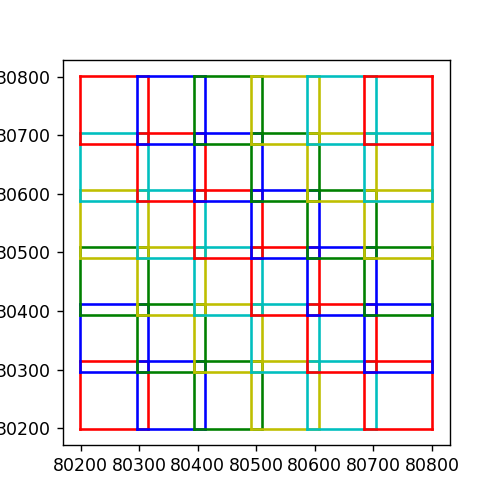

(80169.275009, 80830.6482886, 30169.1975522, 30830.570831800003)

In [8]:
# Before removing overlap
colors = ["r", "b", "g", "y", "c"]

fig, ax = plt.subplots(figsize=(4,4))
cix = 0
for block in overlap_blocks.flatten():
    left = block.left
    right = block.right
    top = block.top
    bottom = block.bottom
    color = colors[cix%len(colors)]
    cix = cix+1

    ax.plot([left, right], [top, top], color)     # Top edge
    ax.plot([right, right], [top ,bottom], color)   # Right edge
    ax.plot([right, left], [bottom, bottom], color)   # Bottom edge
    ax.plot([left, left], [bottom, top], color)     # Left edge
    
ax.axis("equal")

<IPython.core.display.Javascript object>


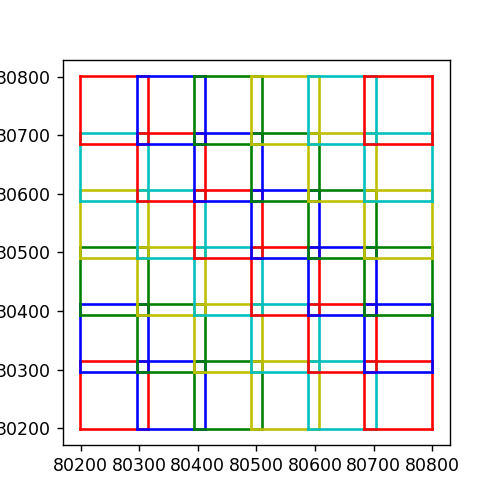

(80169.286359, 80830.40993860002, 30169.2089022, 30830.3324818)

In [9]:
# After removing overlap
colors = ["r", "b", "g", "y", "c"]

fig, ax = plt.subplots(figsize=(4,4))
cix = 0
for block in overlap_blocks.flatten():
    if True: #cix%2 == 0:
        left = block.left + block.xidx[0]*block.xvoxel
        right = block.left + block.xidx[-1]*block.xvoxel
        top = block.bottom + block.yidx[-1]*block.yvoxel
        bottom = block.bottom + block.yidx[0]*block.yvoxel
        color = colors[cix%len(colors)]

        ax.plot([left, right], [top, top], color)     # Top edge
        ax.plot([right, right], [top ,bottom], color)   # Right edge
        ax.plot([right, left], [bottom, bottom], color)   # Bottom edge
        ax.plot([left, left], [bottom, top], color)     # Left edge
    cix = cix+1

ax.axis("equal")
# ax.set_xlim(79000,87000)
# ax.set_ylim(36000,42000)